In [1]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/infrared-solar-modules/LICENSE
/kaggle/input/infrared-solar-modules/README.md
/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules/module_metadata.json
/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules/images/19812.jpg
/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules/images/16916.jpg
/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules/images/7981.jpg
/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules/images/12666.jpg
/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules/images/13288.jpg
/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules/images/6234.jpg
/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules/images/1269.jpg
/kaggle/input/infrared-solar-modules/2020-02-14_Inf

# imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import cv2 as cv
import random
import tensorflow as tf
np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential

2024-06-25 07:37:01.769603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 07:37:01.769738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 07:37:01.883440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing

In [3]:
data_path = "/kaggle/input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules"
metadata_path = os.path.join(data_path, 'module_metadata.json')

In [4]:
df = pd.read_json(metadata_path, orient='index').sort_index()

In [5]:
df["image_filepath"] = df.image_filepath.apply(lambda x: os.path.join(data_path, x))

In [18]:
df.shape

(20000, 2)

In [19]:
labels = df["anomaly_class"]
labels.value_counts()

anomaly_class
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64

In [20]:
import cv2 as cv

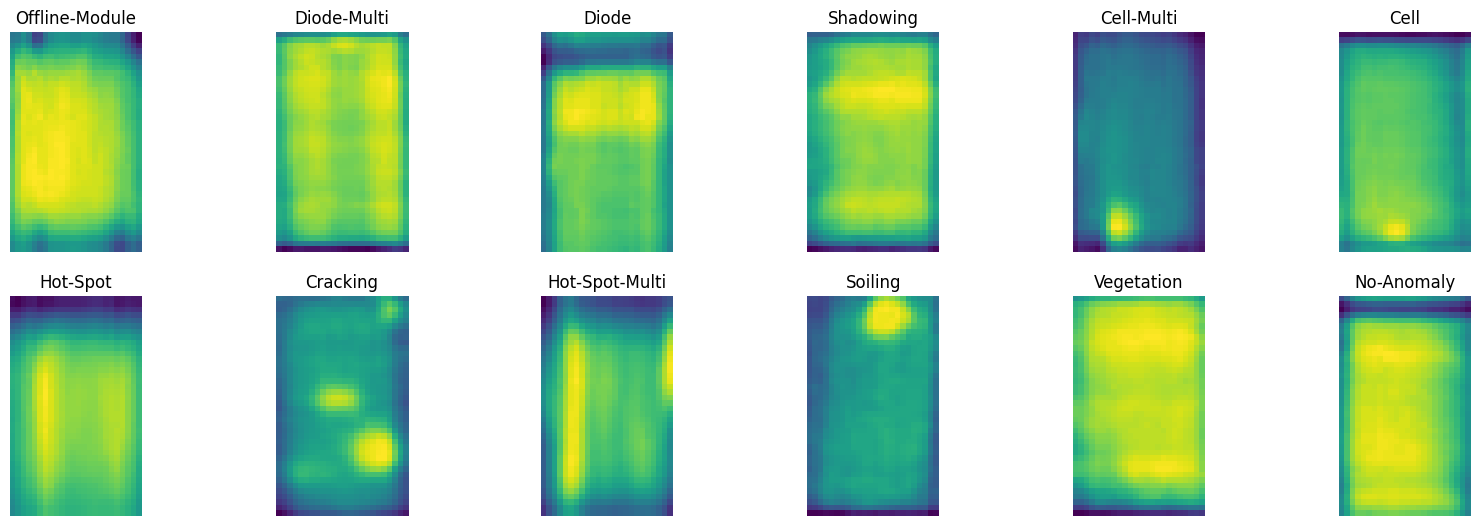

In [21]:
unique_labels = labels.unique()

plt.figure(figsize = (20,20))

for i, class_name in enumerate(unique_labels, start = 1):
    sample = df[df["anomaly_class"] == class_name].sample(n=1).iloc[0]
    image = cv.imread(sample['image_filepath'], 0)
    plt.subplot(6,6,i)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")
    
plt.show()

### removing hot_spot and multi-spot as said in the ReadMe file

In [22]:
# removing hot_spot and multi-spot

crystal_df = df.query("anomaly_class != ('Hot-Spot','Hot-Spot-Multi')")
crystal_df.shape

(19505, 2)

The shape of an image in the dataset is (40, 24)


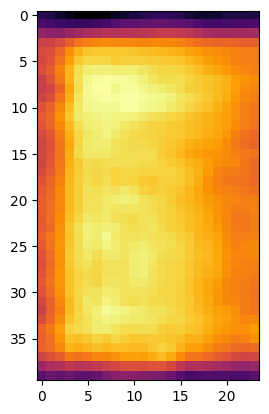

In [23]:
#shape of 1 image

img = cv.imread(df.sample(1)["image_filepath"].values[0],0)
print(f"The shape of an image in the dataset is {img.shape}")
plt.imshow(img, cmap = "inferno")


In [24]:
type(img)

numpy.ndarray

In [25]:
crystal_df["anomaly_class"].nunique()

10

In [26]:
crystal_df["anomaly_class"].value_counts()

anomaly_class
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Soiling             204
Diode-Multi         175
Name: count, dtype: int64

### to make a balanced data, we will augment some images for all classes except "No-Anomaly"

### so will augment images only on the train part, and test part will remain as it is

In [27]:
df_train, df_test = train_test_split(crystal_df, test_size = 0.3, random_state = 42)

## Data Augmentation By Adding Contrasted Images

In [28]:
img_path = df[df["anomaly_class"] == "Cracking"].sample(1)["image_filepath"].values[0]

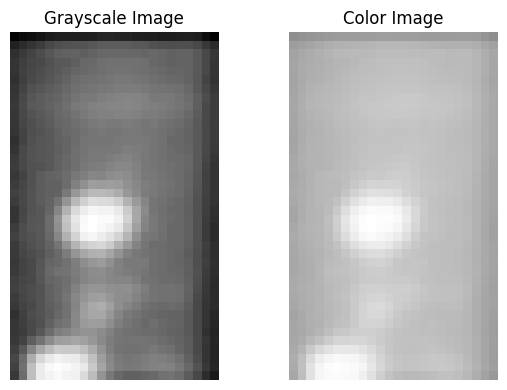

In [29]:
image = cv.imread(img_path, 0) ## to read in grayscale
image2 = cv.imread(img_path)  ## to read in color

fig, ax = plt.subplots(1, 2, figsize=(6,4))  # 1 row, 2 columns
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Grayscale Image")
ax[0].axis('off')  # Hide the axis

# Plot the color image
# converting bgr to rgb(for matplotlib format)
image_color_rgb = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
ax[1].imshow(image2)
ax[1].set_title("Color Image")
ax[1].axis('off')  # Hide the axis

# Show the plot
plt.tight_layout()
plt.show()

Thus all our images are already grayscale, thus it's better to read images in grayscale to reduce their shape from (40,24,3) to (40,24) and reduce computation

Thus we'll read images in grayscale -- cv.imread(img, 0)

### Why only contrast?
Since there are many image augmentation techniques but I am only using contrast adding, because we shouldn't crop the images since there is randomness in defects placement.
Also since the quality of image is already so low, we won't be using blurring techniques as it would worsen the images.

SMOTE didn't show much improvement, so SMOTE application has been removed.

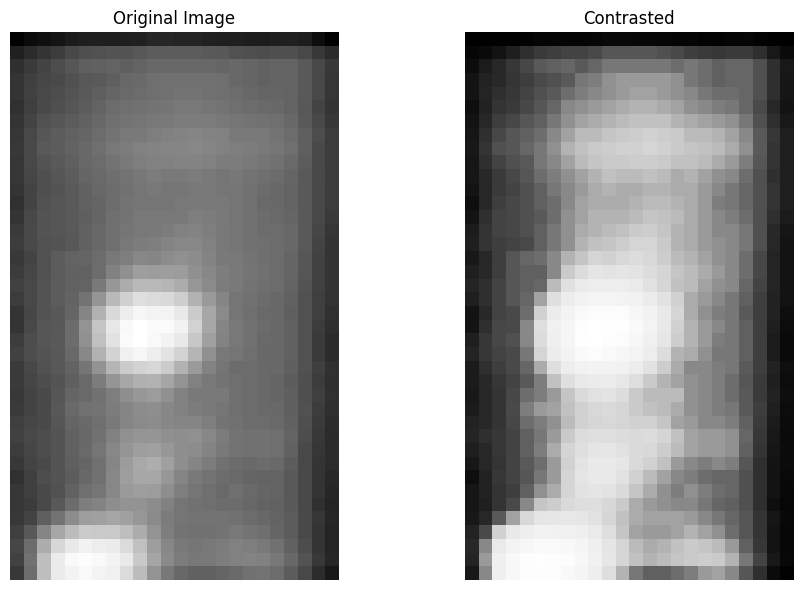

In [30]:
def increase_contrast(image):
    equalized_img = cv.equalizeHist(image)
    return equalized_img

# increase contrast
contrast_img = increase_contrast(image)

fig, ax = plt.subplots(1, 2, figsize=(10,6))

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(contrast_img, cmap='gray')
ax[1].set_title("Contrasted")
ax[1].axis('off')
plt.tight_layout()
plt.show()

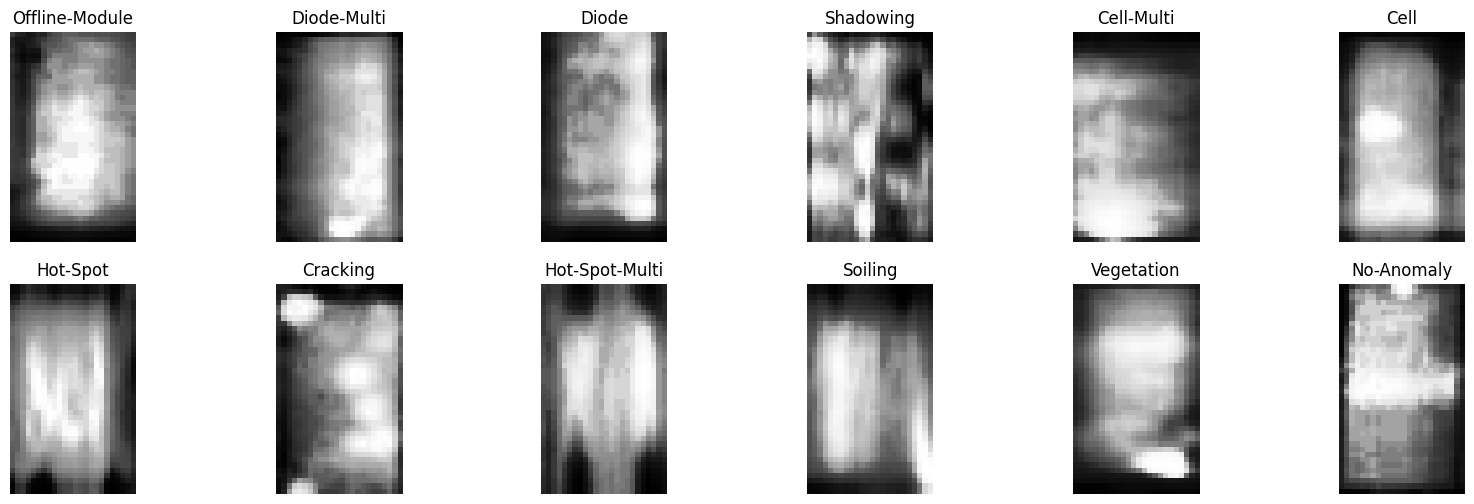

In [31]:
unique_labels = df["anomaly_class"].unique()

fig, ax = plt.subplots(2, 6, figsize=(20,6))
ax = ax.flatten() 

for i, class_name in enumerate(unique_labels, start = 0):
    sample = df[df["anomaly_class"] == class_name].sample(n=1).iloc[0]
    image = cv.imread(sample['image_filepath'], 0)
    
    contrasted = increase_contrast(image)
    
    
    ax[i].imshow(contrasted, cmap = "gray")
    ax[i].set_title(class_name)
    ax[i].axis('off')
plt.axis("off")  
plt.show()

In [32]:
contrasted.shape

(40, 24)

## Image Augmentation on only Train set(on non-majority classes)

## preparing train set

##### NORMAL IMAGES

In [33]:
data1 = []
labels1 = []

for img_path in df_train["image_filepath"]:
    try:
        img = cv.imread(img_path,0) # 0 to read image in grayscale # so the sahpe will be (40,24) instead of (40,24,3)
        
        # Check if image dimensions match (40, 24)
        if img.shape == (40, 24):
            #appling contrast
            contrast_img = increase_contrast(img)
            data1.append(img)
            
            # Append labels
            label = df_train.loc[df_train["image_filepath"] == img_path, "anomaly_class"].values[0]
            labels1.append(label)
            
    except Exception as e:
        print(f"Error processing image {img_path}: {str(e)}")

# Convert lists to numpy arrays
data1 = np.array(data1)
labels1 = np.array(labels1)

data1 = data1/255.0

##### CONTRASTED IMAGES

In [34]:
data2 = []
labels2 = []

# taking the non-majority classes from the train set
for img_path in df_train[df_train["anomaly_class"] != "No-Anomaly"]["image_filepath"]:
    try:
        img = cv.imread(img_path,0)
        
        # Check if image dimensions match (40, 24)
        if img.shape == (40, 24):
            data2.append(img)
            
            # Append labels
            label = df_train.loc[df_train["image_filepath"] == img_path, "anomaly_class"].values[0]
            labels2.append(label)
            
    except Exception as e:
        print(f"Error processing image {img_path}: {str(e)}")

# Convert lists to numpy arrays
data2 = np.array(data2)/255.0
labels2 = np.array(labels2)

In [35]:
data1.shape, labels1.shape
data2.shape, labels2.shape

((13653, 40, 24), (13653,))

##### CONCATENATING BOTH

In [36]:
data_train = np.concatenate((data1, data2), axis=0)
labels_train = np.concatenate((labels1, labels2), axis = 0)
data_train.shape, labels_train.shape

((20283,), (20283, 40, 24))

## preparing test set

In [37]:
x_test = []
y_test = []

for img_path in df_test["image_filepath"]:
    try:
        img = cv.imread(img_path,0)
        
        # Check if image dimensions match (40, 24)
        if img.shape == (40, 24):
            x_test.append(img)
            
            # Append labels
            label = df_test.loc[df_test["image_filepath"] == img_path, "anomaly_class"].values[0]
            y_test.append(label)
            
    except Exception as e:
        print(f"Error processing image {img_path}: {str(e)}")

# Convert lists to numpy arrays
x_test = np.array(x_test)/255.0
y_test = np.array(y_test)

In [38]:
x_test.shape, y_test.shape

(5852, 40, 24)

In [39]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(labels_train)
y_train = to_categorical(y_train, 10)

y_test = encoder.fit_transform(y_test)
y_test = to_categorical(y_test, 10)

y_train.shape, y_test.shape

((20283, 10), (5852, 10))

In [40]:
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label Mapping: \n",label_mapping)

Label Mapping: 
 {'Cell': 0, 'Cell-Multi': 1, 'Cracking': 2, 'Diode': 3, 'Diode-Multi': 4, 'No-Anomaly': 5, 'Offline-Module': 6, 'Shadowing': 7, 'Soiling': 8, 'Vegetation': 9}


# ---------------------------------------------------------------------
# accuracy: 0.8077

In [62]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding = "same", activation = "relu", input_shape = (40,24,1)))
#model.add(BatchNormalization())
#model.add(MaxPool2D())

model.add(Conv2D(64, (3,3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(256, (3,3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(256, (3,3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(512, (3,3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256, activation ="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation ="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation ="softmax"))

print(model.summary())

In [63]:
opt= tf.keras.optimizers.Adam(learning_rate  = 1e-4)
model.compile(optimizer = opt, metrics = ["accuracy","AUC","F1Score"], loss = "categorical_crossentropy")

In [64]:
history_train = model.fit(data_train, y_train, batch_size = 64, validation_split = 0.2, epochs = 70)

W0000 00:00:1719303083.289400     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719303093.151108     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719303094.506279     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719303096.236767     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [67]:
print(f"Validation accuracy: {history_train.history['val_accuracy'][-1]}\nTrain accuracy: {history_train.history['accuracy'][-1]}\n")
print(f"Validation AUC: {history_train.history['val_AUC'][-1]}\nTrain AUC: {history_train.history['AUC'][-1]}\n")

Validation accuracy: 0.9775696396827698
Train accuracy: 0.9906322956085205

Validation AUC: 0.9978910684585571
Train AUC: 0.9995455741882324



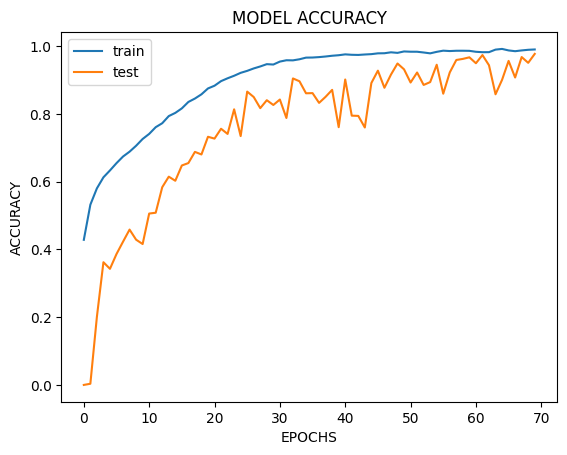

In [66]:
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history["val_accuracy"])
plt.title("MODEL ACCURACY")
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
history_test = model.evaluate(x_test, y_test, batch_size = 64)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9347 - F1Score: 0.6642 - accuracy: 0.8077 - loss: 1.6606


# TRAIN_ACCURACY = 99.06%,    TEST_ACCURACY = 80.77% 
# TRAIN_AUC = 0.9978,     TEST_AUC = 0.9347

# ----------------------------------------------------------